In [1]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
%matplotlib inline


from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

import skimage
from skimage import filters

 
def BiggestRegion(array):
    labels,num = skimage.measure.label(array, connectivity=3,return_num='Ture')
    if num>1:
        props = skimage.measure.regionprops(labels)
        b = [p.area for p in props]
        ind = b.index(max(b))
        bcoords = props[ind].coords
        b_loop = np.zeros((array.shape))
        for i in range(len(bcoords)):
                a,b,c = bcoords[i]
                b_loop[a,b,c]=1
    else:
        b_loop = array
        
    return b_loop

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    


def saveImage(array,img):
    array = np.swapaxes(array,0,2)
    mask = sitk.GetImageFromArray(array)
    mask.CopyInformation(img)
    sitk.WriteImage(mask, os.path.split(path)[0] + '/ROI.nii.gz')




In [2]:
# paths =['/MachineLearning/python tutorials/tutorial3/',
#         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample3/',
#         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample6/',
#          '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample4/',
#          '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample5/S5_Pre_rigid.nrrd',
#          '/Users/fair00542/Desktop/TestImages/ScanB/ScanB',
#          '/Users/fair00542/Desktop/TestImages/ScanF/ScanF']

paths =['/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanB/ScanB_HeadC_SpineTraumaSeq_20141102100723_7_Tilt_Eq_1.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanD/ScanD_HeadC_SpineTrauma_20150402224947_6_Tilt_1.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanE/ScanE_HeadC_SpineTrauma_20150611023452_3.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanF/ScanF_HeadC_SpineTrauma_20150515234756_6.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanG/ScanG_HeadC_SpineTrauma_20150727175302_3.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanH/ScanH_1.25MM_RECONS_20150724224900_4_Tilt_Eq_1.nii.gz',
       '/Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanI/ScanI_HeadC_SpineTrauma_20150712185123_3_Tilt_1.nii.gz']


path = paths[2]
print( "Reading Dicom directory:", path)

# if Dicom
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames(path)
# reader.SetFileNames(dicom_names)
# img = reader.Execute()
# img = sitk.ReadImage(dicom_names)
# msk = sitk.ReadImage(path + '/opt_foramen_cut.nii.gz')

img = sitk.ReadImage(os.path.split(path)[0] + '/Final_midplane.nii.gz')
img_array = sitk.GetArrayFromImage(img)
img_array = np.swapaxes(img_array,0,2)
ConstPixelSpacing = img.GetSpacing()

mask = sitk.ReadImage(os.path.split(path)[0] + '/SEG5.nii.gz')
Mask_array = sitk.GetArrayFromImage(mask)
Mask_array = np.swapaxes(Mask_array,0,2)

V_mask = sitk.ReadImage(os.path.split(path)[0] + '/V.nii.gz')
V_mask_array = sitk.GetArrayFromImage(V_mask)
V_mask_array = np.swapaxes(V_mask_array,0,2)




#Import ideal midplane parameters
paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Scans_para.npy')
# pa = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/tutorial3.npy')

# print('CT image')
# display_image(img, x=200, y=200, z=100, window=120, level=40)

# print('Brain mask')
# display_image(msk, x=200, y=200, z=100)

Reading Dicom directory: /Volumes/FAIR/Sinead/DC-Project-Images/ScanFiles_Dicom/ScanE/ScanE_HeadC_SpineTrauma_20150611023452_3.nii.gz


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Scans_para.npy'

In [231]:
Mask_array.shape,V_mask_array.shape

((512, 512, 243), (512, 512, 243))

# Find the right mask

In [265]:
# Make sure the masks are binary!! Or it messed up the rotation

ROI_array = np.zeros(Mask_array.shape)
# ROI_array[Mask_array == 1] = 1
# ROI_array[Mask_array == 3] = 1
# ROI_array[Mask_array == 5] = 1
ROI_array[Mask_array == 2] = 1
# ROI_array[Mask_array == 4] = 1

# label 4 and 3 are haematoma
# H_mask = BiggestRegion(ROI_array)

H_mask = ROI_array
# reverse_v = np.ones((V_mask_array.shape))
# reverse_v[V_mask_array == 1] = 0

H_mask1 = bc(bd(ROI_array)).astype(ROI_array.dtype)
# B_mask = (np.multiply(H_mask1,reverse_v)).astype(V_mask_array.dtype)
# B_mask = bo(B_mask).astype(V_mask_array.dtype)
H_mask2 = bc(bc(H_mask1)).astype(H_mask.dtype)
H_mask3 = bfh(H_mask1).astype(H_mask.dtype)

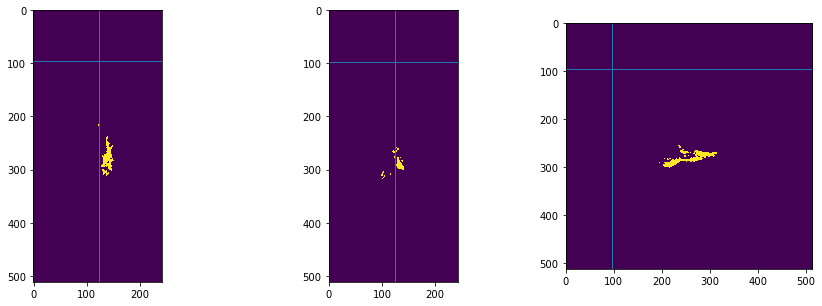

In [266]:
# Dilate ventricle masks
V_mask_array = bc(bd(V_mask_array,structure = np.ones((2,2,1)))).astype(V_mask_array.dtype)
NewCore.displayMask(V_mask_array,ConstPixelSpacing,270,211,138)


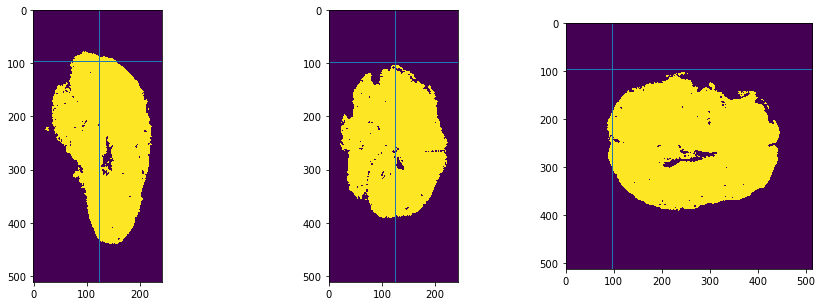

In [270]:
# Brain Mask, doing the subtractions 
B_mask = np.zeros(Mask_array.shape)
B_mask[Mask_array>0]=1

reverse_v = np.ones((V_mask_array.shape))
reverse_v[V_mask_array == 1] = 0
B_mask = np.multiply(B_mask,reverse_v).astype(B_mask.dtype)

reverse_H = np.ones((H_mask2.shape))
reverse_H[H_mask2 == 1] = 0
B_mask = np.multiply(B_mask,reverse_H).astype(reverse_H.dtype)



NewCore.displayMask(B_mask,ConstPixelSpacing,270,211,138)

In [271]:
# kk = NewCore.BiggestRegion(B_mask2)
# # kk = BiggestRegion(B_mask2)
active_mask = B_mask
# saveImage(active_mask,img)

In [272]:
Volume = np.sum(active_mask)*ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]
Volume

1275423.9440833451

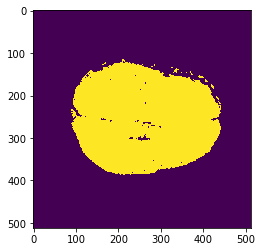

In [273]:
plt.imshow(active_mask[:,:,150])

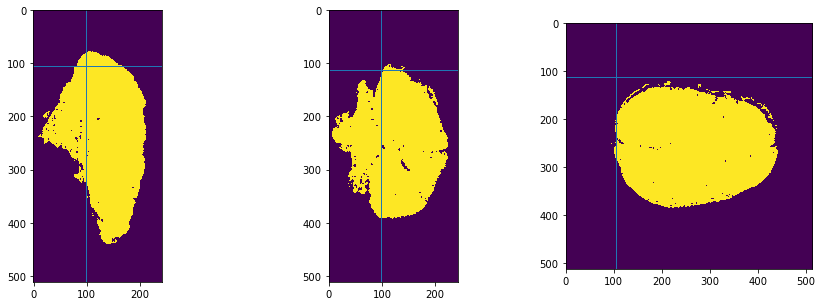

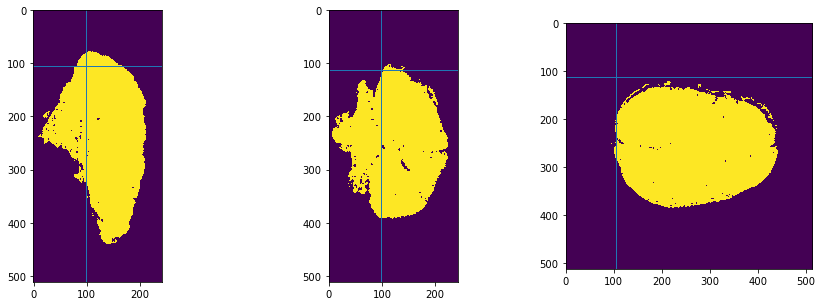

In [274]:
NewCore.displayMask(active_mask,ConstPixelSpacing,216,229,160)
NewCore.displayMask(B_mask,ConstPixelSpacing,216,229,160)

In [275]:
paras[2]

array([b'ScanE', b'-0.994486220042', b'0.00842368764635',
       b'0.104528463268', b'-231.755654009'],
      dtype='|S16')

In [3]:
# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
file, a, b, c, d = paras[2]
a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
v = np.array((a,b,c))
v = v.astype(float)
print(file, a, b, c, d, path)

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

# ML_array = array
# ideal midplane
Ideal_ML = np.multiply(img_array == 1,img_array)
mask = active_mask

from scipy.ndimage.interpolation import rotate
r_IML = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
r2_IML = rotate(r_IML,A_S,mode='constant',axes=(0,2))

r_mask = rotate(mask,A_O,mode='constant',axes=(0,1))
r2_mask = rotate(r_mask,A_S,mode='constant',axes=(0,2))

# Turn r2-IML into binary as well

NameError: name 'paras' is not defined

In [4]:
plt.imshow(r2_mask[:,:,101])

NameError: name 'r2_mask' is not defined

In [278]:
Binary_Mask = np.zeros(r2_IML.shape)
Binary_Mask[np.abs(r2_IML)>0.4]=1
r2_IMLq = Binary_Mask

# x1,y1,z1 = np.nonzero(r2_DML)
# # x1,y1,z1 = x*ConstPixelSpacing[0],y*ConstPixelSpacing[1],z*ConstPixelSpacing[2]
# y1 = y1.astype(int)
# z1 = z1.astype(int)

NameError: name 'r2_IMLq' is not defined

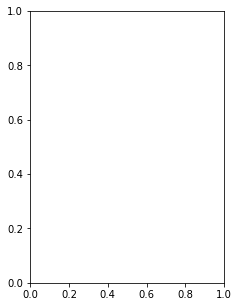

In [5]:
i = 100

plt.figure(figsize=(16,5))
plt.subplot(141)

# plt.imshow(mask[:,i,:])



plt.imshow(r2_IMLq[:,i,:])
plt.subplot(142)
plt.imshow(Ideal_ML[:,i,:])
plt.show()

In [280]:
# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
xr = np.nonzero(r2_IMLq)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

reference_x

# print('Number of points ' + str(num_pts))
# counts = np.bincount(np.nonzero(r2_IML)[0])
# reference_x = np.argmax(counts)
# print(reference_x)

261

In [290]:
# Somehow the rotated mask is not binary, needs clarification.
Binary_Mask = np.zeros(r2_mask.shape)
Binary_Mask[np.abs(r2_mask)>0.98]=1

# Adjust the threshold level until the number of active pixels become approximately the same
np.sum(np.nonzero(mask)),np.sum(np.nonzero(Binary_Mask)),

(5457155873, 5526677776)

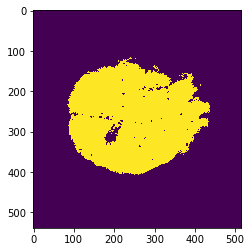

In [291]:
plt.imshow(Binary_Mask[:,:,150])

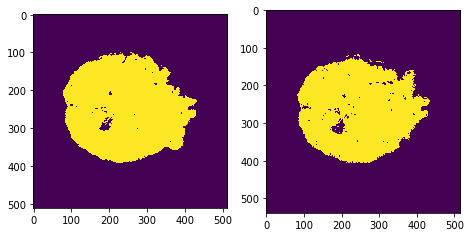

In [292]:
# View the rotation from axial plane
i = 120.0
i2 = int((i/mask.shape[2])*r2_mask.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(mask[:,:,int(i)])
plt.subplot(142)
plt.imshow(Binary_Mask[:,:,i2])


plt.show()

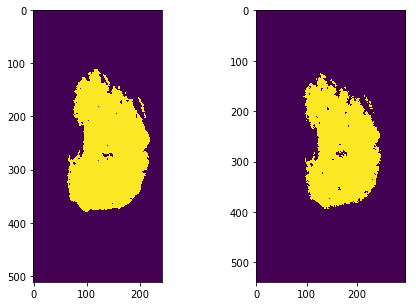

In [293]:
# View the rotation from coronal plane
i1 = 300.0
i2 = int((i1/mask.shape[1])*r2_mask.shape[1])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(mask[:,int(i1),:])
plt.subplot(142)
plt.imshow(Binary_Mask[:,i2,:])


plt.show()

In [294]:
midplane_split = np.zeros(r2_IMLq.shape)
for i in range(reference_x-1,r2_IMLq.shape[0]):
    midplane_split[i,:,:] = 1

Left_mask = np.multiply(Binary_Mask,midplane_split==0)
Right_mask = np.multiply(Binary_Mask,midplane_split==1)

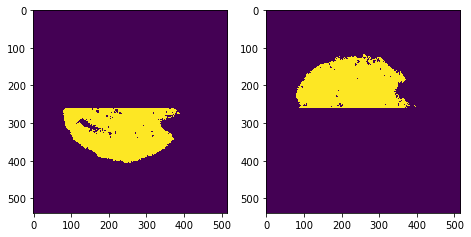

In [295]:
# View the rotation from axial plane
i1 = 106.0
i2 = int((i1/mask.shape[2])*r2_mask.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Right_mask[:,:,i2])
plt.subplot(142)
plt.imshow(Left_mask[:,:,i2])


plt.show()

In [296]:
Left_sum = np.sum(Left_mask,0)
Right_sum = np.sum(Right_mask,0)
H_diff = Left_sum-Right_sum
y,z = np.nonzero(H_diff)
# H_diff[H_diff==0]=np.nan

Brain_mask = np.zeros((int(z.max()+1.0),int(y.max()+1.0)))
for i in range(len(z)):
    Brain_mask[z[i],y[i]]= H_diff[y[i],z[i]]

<IPython.core.display.Javascript object>


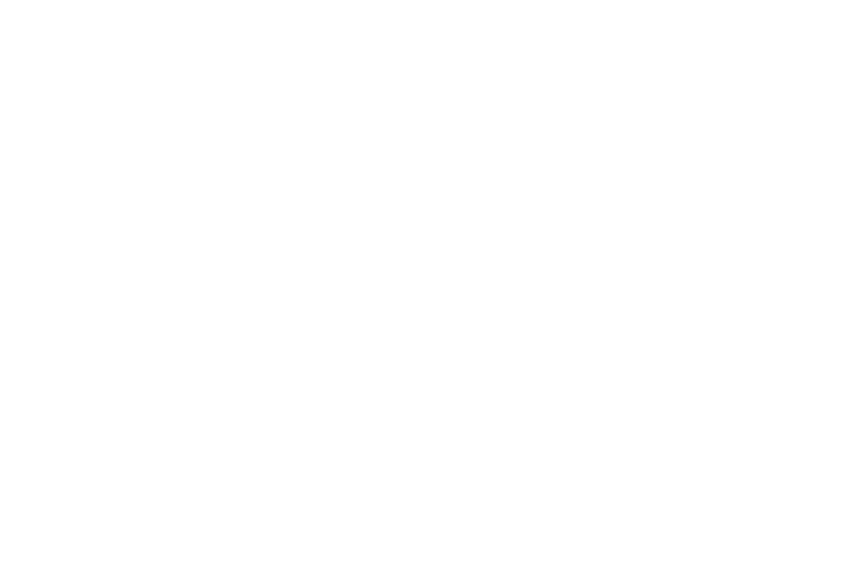

<IPython.core.display.Javascript object>


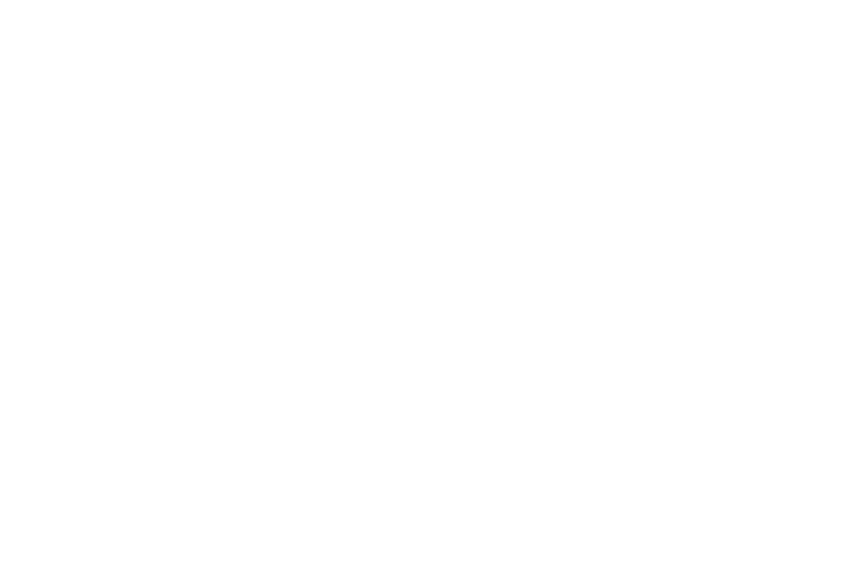

In [219]:
%matplotlib nbagg
fig, ax = plt.subplots()
Brain_mask[Brain_mask==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(Brain_mask, cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
# plt.ylim(20, z.max())
# plt.ylim(20,140)
# plt.xlim (y.min(),y.max())
# plt.xlim (50,500)
ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
plt.ion()

In [59]:
plt.savefig('H_assymetry_SCI.png')

In [297]:
import scipy.io
mm = np.array([y,z,H_diff[H_diff!=0]])
ConstPixelSpacing = np.array([ConstPixelSpacing[0],ConstPixelSpacing[1],ConstPixelSpacing[2],H_diff.max()])
scipy.io.savemat('B_asymetry_SCE.mat',{'mm':mm,'ConstPixelSpacing':ConstPixelSpacing})

In [149]:
np.swapaxes(Binary_Mask,0,2)
Rotated_mask = sitk.GetImageFromArray(Binary_Mask)
Rotated_mask.CopyInformation(img)
sitk.WriteImage(Rotated_mask, os.path.split(path)[0] + '/rot_H_mask.nii.gz')


RuntimeError: Exception thrown in SimpleITK Image_CopyInformation: /scratch/dashboards/SimpleITK-OSX10.6-intel-pkg/SimpleITK/Code/Common/src/sitkImage.cxx:228:
sitk::ERROR: Source image size of [ 512, 601, 167 ] does not match this image's size of [ 182, 635, 556 ]!